In [1]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [2]:
client = MongoClient()
loladb = client.loladb77
summoners_collection = loladb.summoners
matches_collection = loladb.matches

In [121]:
print matches_collection.count()
print summoners_collection.count()

24204
48527


In [112]:
#stats about player rank distribution
player_dict = {}
for a_idx, a_summoner in enumerate(summoners_collection.find()):
    player_dict[a_summoner["name"]] = ""

rank_dict = {}
for a_idx, a_match in enumerate(matches_collection.find()):
    for a_member in a_match["blue_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        rank_dict[a_rank] = 0
    for a_member in a_match["red_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        rank_dict[a_rank] = 0    

In [113]:
print rank_dict

{u'Level 5': 0, u'Level 6': 0, u'Level 3': 0, u'Silver 3': 0, u'Silver 2': 0, u'Silver 1': 0, u'Level 9': 0, u'Level 8': 0, u'Silver 5': 0, u'Silver 4': 0, u'Platinum 2': 0, u'Platinum 3': 0, u'Platinum 1': 0, u'Master': 0, u'Platinum 4': 0, u'Platinum 5': 0, u'Gold 4': 0, u'Gold 5': 0, u'Bronze 2': 0, u'Bronze 3': 0, u'Bronze 4': 0, u'Gold 1': 0, u'Gold 2': 0, u'Gold 3': 0, u'Level 28': 0, u'Level 29': 0, u'Diamond 2': 0, u'Level 20': 0, u'Level 21': 0, u'Level 22': 0, u'Level 23': 0, u'Level 24': 0, u'Level 25': 0, u'Level 26': 0, u'Level 27': 0, u'Bronze 1': 0, u'Unranked': 0, u'Diamond 4': 0, u'Diamond 1': 0, u'Diamond 3': 0, u'Bronze 5': 0, u'Diamond 5': 0, u'Level 11': 0, u'Challenger': 0, u'Level 13': 0, u'Level 12': 0, u'Level 15': 0, u'Level 14': 0, u'Level 17': 0, u'Level 16': 0, u'Level 19': 0, u'Level 18': 0, u'Level 30': 0}


In [114]:
def GetRankNumber(a_rank):
    rank_words = a_rank.split(' ')
    if rank_words[0] == "Level" or rank_words[0] == "Unranked":
        return -1
    
    result = 0
    if rank_words[0] == "Bronze":
        result = 0
    elif rank_words[0] == "Silver":
        result = 10
    elif rank_words[0] == "Gold":
        result = 20
    elif rank_words[0] == "Platinum":
        result = 30
    elif rank_words[0] == "Diamond":
        result = 40
    else:
        result = 50
    
    if len(rank_words) == 2:
        if rank_words[1] == "1":
            result += 8
        if rank_words[1] == "2":
            result += 6
        if rank_words[1] == "3":
            result += 4
        if rank_words[1] == "4":
            result += 2
    return result   

In [115]:
for each_key in rank_dict:
    print each_key, GetRankNumber(each_key)

Level 5 -1
Level 6 -1
Level 3 -1
Silver 3 14
Silver 2 16
Silver 1 18
Level 9 -1
Level 8 -1
Silver 5 10
Silver 4 12
Platinum 2 36
Platinum 3 34
Platinum 1 38
Master 50
Platinum 4 32
Platinum 5 30
Gold 4 22
Gold 5 20
Bronze 2 6
Bronze 3 4
Bronze 4 2
Gold 1 28
Gold 2 26
Gold 3 24
Level 28 -1
Level 29 -1
Diamond 2 46
Level 20 -1
Level 21 -1
Level 22 -1
Level 23 -1
Level 24 -1
Level 25 -1
Level 26 -1
Level 27 -1
Bronze 1 8
Unranked -1
Diamond 4 42
Diamond 1 48
Diamond 3 44
Bronze 5 0
Diamond 5 40
Level 11 -1
Challenger 50
Level 13 -1
Level 12 -1
Level 15 -1
Level 14 -1
Level 17 -1
Level 16 -1
Level 19 -1
Level 18 -1
Level 30 -1


In [116]:
for a_idx, a_match in enumerate(matches_collection.find()):
    for a_member in a_match["blue_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        a_rank_value = GetRankNumber(a_rank)
        player_dict[a_player] = a_rank_value
    for a_member in a_match["red_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        a_rank_value = GetRankNumber(a_rank)
        player_dict[a_player] = a_rank_value

In [117]:
unranked = 0
bronze_num = 0
silver_num = 0
gold_num = 0
plat_num = 0
diamond_num = 0
for a_idx, a_player in enumerate(player_dict):
    #print a_player, player_dict[a_player]
    a_rank_value = player_dict[a_player]
    if a_rank_value < 0:
        unranked += 1
    elif a_rank_value < 10:
        bronze_num += 1
    elif a_rank_value < 20:
        silver_num += 1
    elif a_rank_value < 30:
        gold_num += 1
    elif a_rank_value < 40:
        plat_num += 1
    elif a_rank_value < 50:
        diamond_num += 1

In [118]:
print unranked, bronze_num, silver_num, gold_num, plat_num, diamond_num
print unranked + bronze_num + silver_num + gold_num + plat_num + diamond_num

4252 3060 21610 13466 4282 323
46993


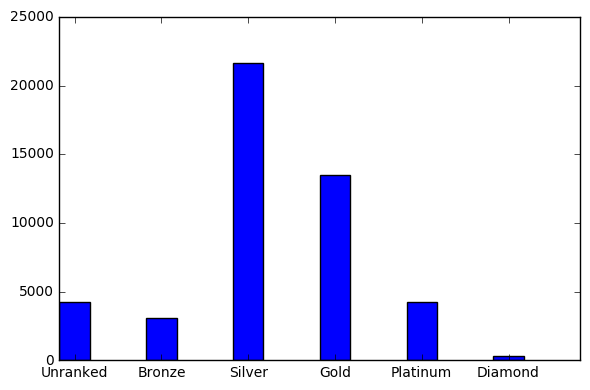

In [119]:
bar_width = 0.35

plt.bar(np.arange(6), [unranked, bronze_num, silver_num, gold_num, plat_num, diamond_num], bar_width)
plt.xticks(np.arange(6) + bar_width / 2, ('Unranked', 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond'))
plt.tight_layout()
plt.show()

In [99]:
champion_dict = {}
for a_idx, a_match in enumerate(matches_collection.find()):
    for a_member in a_match["blue_team"]:
        a_champion = a_member["champion_name"]
        champion_dict[a_champion] = []
    for a_member in a_match["red_team"]:
        a_champion = a_member["champion_name"]
        champion_dict[a_champion] = []

In [100]:
#stats on overall champion carry rate
for a_idx, a_match in enumerate(matches_collection.find()):
            
    if a_idx % 10000 == 0:
        print a_idx
        
    has_unranked = False
    champions_data = []
    rank_sum = 0
    for a_member in a_match["blue_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        a_champion = a_member["champion_name"]
        a_rank_value = GetRankNumber(a_rank)
        champions_data.append({"name":a_champion, "rank":a_rank_value, "win":a_match["match_winner"]==0})
        rank_sum += a_rank_value
        if a_rank_value < 0:
            has_unranked = True
            break
        
    for a_member in a_match["red_team"]:
        a_rank = a_member["player_tier"]
        a_player = a_member["player_name"]
        a_champion = a_member["champion_name"]
        a_rank_value = GetRankNumber(a_rank)
        player_dict[a_player] = a_rank_value
        champions_data.append({"name":a_champion, "rank":a_rank_value, "win":a_match["match_winner"]==1})
        rank_sum += a_rank_value
        if a_rank_value < 0:
            has_unranked = True
            break
            
    if has_unranked:
        continue
        
    rank_average = rank_sum / 10.0
    for a_data in champions_data:
        a_data["rank"] -= rank_average
        champion_dict[a_data["name"]].append({"rank":a_data["rank"], "win":a_data["win"]})



0
10000


In [101]:
print len(champion_dict)
print champion_dict.keys()

137
[u'', u'Jax', u'Twisted Fate', u'Shaco', u'Warwick', u'Xayah', u'Nidalee', u'Zyra', u'Kled', u'Brand', u'Rammus', u'Illaoi', u'Corki', u'Braum', u'Anivia', u'Tryndamere', u"Kha'Zix", u'Yorick', u'Xerath', u'Sivir', u'Riven', u'Orianna', u'Gangplank', u'Malphite', u'Miss Fortune', u'Poppy', u"Vel'Koz", u'Karthus', u'Jayce', u'Diana', u'Trundle', u'Sejuani', u'Graves', u'Lucian', u'Gnar', u'Lux', u'Shyvana', u'Renekton', u'Fiora', u'Jinx', u'Kalista', u'Fizz', u'Kassadin', u'Sona', u'Tahm Kench', u'Vladimir', u'Viktor', u'Rakan', u'Kindred', u'Cassiopeia', u'Maokai', u'Thresh', u'Kayle', u'Hecarim', u'Lee Sin', u'Nunu', u'Olaf', u'Ziggs', u'Syndra', u'Karma', u'Annie', u'Akali', u'Leona', u'Yasuo', u"Cho'Gath", u'Rengar', u'Ryze', u'Shen', u'Zac', u'Teemo', u'Pantheon', u'Swain', u'Bard', u'Sion', u'Vayne', u'Nasus', u'Fiddlesticks', u'Udyr', u"Rek'Sai", u'Morgana', u'Ivern', u'LeBlanc', u'Caitlyn', u'Darius', u'Nocturne', u'Zilean', u'Azir', u'Rumble', u'Skarner', u'Kennen', u'Urgot

In [102]:
print champion_dict["Jax"][0:3]

[{'win': True, 'rank': -0.3999999999999986}, {'win': False, 'rank': -5.199999999999999}, {'win': True, 'rank': 7.800000000000001}]


In [103]:
import pysal

In [104]:
def GetProbitModel(champion_records):
    X = []
    Y = []
    for each_record in champion_records:
        if each_record["win"]:
            Y.append([1])
        else:
            Y.append([0])
        X.append([each_record["rank"]])
        
    model = pysal.spreg.probit.Probit(np.array(Y), np.array(X))
    return model.betas

In [105]:
print GetProbitModel(champion_dict["Blitzcrank"])
print GetProbitModel(champion_dict["Janna"])
print GetProbitModel(champion_dict["Ekko"])
print GetProbitModel(champion_dict["Poppy"])

[[ 0.05308249]
 [ 0.01323023]]
[[ 0.02524652]
 [ 0.0011771 ]]
[[ 0.00671265]
 [ 0.01297954]]
[[-0.01493013]
 [-0.00613855]]


In [106]:
import csv
with open('champion_carry_rate.csv', 'wb') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for a_champion in champion_dict:
        if a_champion == "":
            continue
        probit_result = GetProbitModel(champion_dict[a_champion])
        csvwriter.writerow([a_champion, probit_result[0][0], probit_result[1][0], len(champion_dict[a_champion])])

In [107]:
print champion_dict["Rakan"]

[{'win': True, 'rank': -0.3999999999999986}, {'win': True, 'rank': -6.800000000000001}, {'win': False, 'rank': -5.199999999999999}, {'win': True, 'rank': -7.600000000000001}, {'win': False, 'rank': 0.40000000000000036}, {'win': True, 'rank': 1.6000000000000014}, {'win': True, 'rank': 5.0}, {'win': True, 'rank': 4.0}, {'win': True, 'rank': 2.1999999999999993}, {'win': True, 'rank': -6.799999999999997}, {'win': True, 'rank': -3.0}, {'win': False, 'rank': -2.3999999999999986}, {'win': False, 'rank': -0.1999999999999993}, {'win': False, 'rank': 1.3999999999999986}, {'win': False, 'rank': -1.6000000000000014}, {'win': True, 'rank': 2.8000000000000007}, {'win': False, 'rank': -3.1999999999999993}, {'win': True, 'rank': 3.8000000000000007}, {'win': False, 'rank': 3.3999999999999986}, {'win': True, 'rank': 4.399999999999999}, {'win': True, 'rank': -2.1999999999999993}, {'win': True, 'rank': 1.0}, {'win': False, 'rank': -3.8000000000000007}, {'win': False, 'rank': 0.6000000000000014}, {'win': F